In [1]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 705 kB 32.4 MB/s 
     |████████████████████████████████| 419 kB 69.2 MB/s 
     |████████████████████████████████| 5.9 MB 55.3 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import torchvision
import pytorch_lightning as pl
import torchmetrics
import matplotlib.pyplot as plt

In [3]:
training_data = torchvision.datasets.FashionMNIST(
    root='data'
    , train=True
    , download=True
    , transform = torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.FashionMNIST(
    root='data'
    , train=False
    , download=True
    , transform = torchvision.transforms.ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
train_dataset, val_dataset = random_split(training_data, [55000, 5000])

In [5]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

In [11]:
class LitModel(pl.LightningModule) :
    def __init__(self) :
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            torch.nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            torch.nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            torch.nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
        )
    def forward(self, X) :
        return self.model(X)
    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        return loss
    def validation_step(self, batch, batch_idx) :
        X, y =batch
        logits = self(X)
        acc = torchmetrics.functional.accuracy(logits, y)
        loss = torch.nn.functional.cross_entropy(logits, y)
        metrics = {'val_acc' : acc, 'val_loss' : loss}
        self.log_dict(metrics)
    def test_step(self, batch, batch_idx) :
        X, y = batch
        pred_y = self.model(X)
        acc = torchmetrics.functional.accuracy(pred_y, y)
        loss = torch.nn.functional.cross_entropy(pred_y, y)
        metrics = {'val_acc' : acc, 'val_loss' : loss}
        self.log_dict(metrics)
    def configure_optimizers(self) :
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

In [14]:
model = LitModel()
trainer = pl.Trainer(max_epochs = epochs)
trainer.fit(model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1769: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 552 K 
-------------------------------------
552 K     Trainable params
0         Non-trainable params
552 K     Total params
2.208     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [18]:
trainer.test(dataloaders=test_dataloader) # pl.LightningDataModule 써야할까?

TypeError: ignored

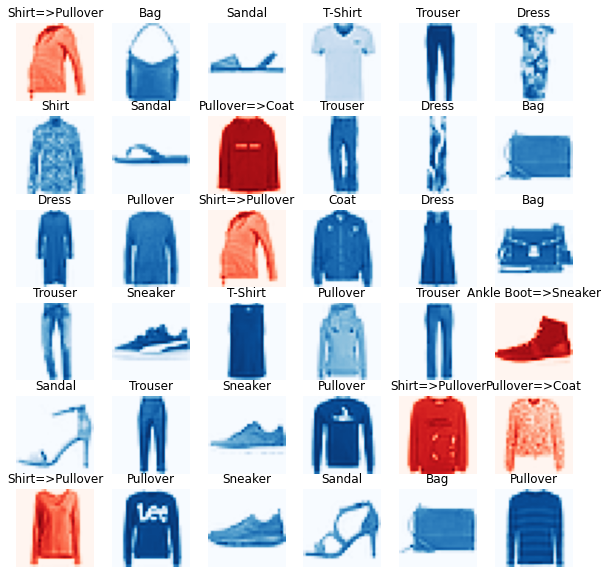

In [19]:
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}
columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = torch.randint(len(test_dataloader),(1,)).item()
    input_img = test_data[data_idx][0].unsqueeze(dim=0)

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = label_tags[argmax.item()]
    label = label_tags[test_data[data_idx][1]]

    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred)
        cmap = 'Blues'
    else:
        plt.title(pred + '=>' +  label)
        cmap = 'Reds'
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')

plt.show() 